In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("awsaf49/brats20-dataset-training-validation")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brats20-dataset-training-validation


In [ ]:
!pip install nilearn
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps

from tensorflow.keras.layers import SpatialDropout3D
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
!pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif
import gif_your_nifti.core as gif2nif

import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

np.set_printoptions(precision=3, suppress=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 36.7 MB/s eta 0:00:00
  Cloning https://github.com/miykael/gif_your_nifti to /tmp/pip-req-build-kz8w79i8
  Running command git clone --filter=blob:none --quiet https://github.com/miykael/gif_your_nifti /tmp/pip-req-build-kz8w79i8
  Resolved https://github.com/miykael/gif_your_nifti to commit 55c09c42921f4871cf43f63a303ab420a92a4f03
  Preparing metadata (setup.py) ... done
  Created wheel for gif_your_nifti: filename=gif_your_nifti-0.2.2-py3-none-any.whl size=6632 sha256=85c50b0ceedaa7d37f67e3242ecf6f079e1df9ba4511a0599d08e0321e792dd7
  Stored in directory: /tmp/pip-ephem-wheel-cache-747m26n6/wheels/de/6d/35/5b931fbea2039fbd2ac937828c719c3cdd70953235af24b9ab
Successfully built gif_your_nifti


In [ ]:
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE',
    2 : 'EDEMA',
    3 : 'ENHANCING'
}

VOLUME_SLICES = 100
VOLUME_START_AT = 22

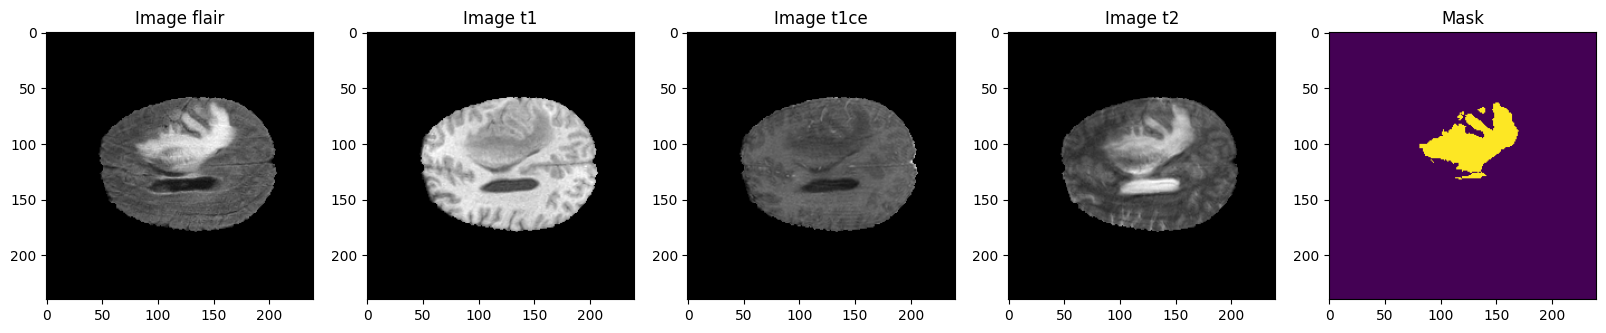

In [ ]:
TRAIN_DATASET_PATH = path + '/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = path + '/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'

import nibabel as nib
import matplotlib.pyplot as plt

# Load the images using the updated path
test_image_flair = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()

# Display the images
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 10))
slice_w = 25

ax1.imshow(test_image_flair[:, :, test_image_flair.shape[0]//2 - slice_w], cmap='gray')
ax1.set_title('Image flair')

ax2.imshow(test_image_t1[:, :, test_image_t1.shape[0]//2 - slice_w], cmap='gray')
ax2.set_title('Image t1')

ax3.imshow(test_image_t1ce[:, :, test_image_t1ce.shape[0]//2 - slice_w], cmap='gray')
ax3.set_title('Image t1ce')

ax4.imshow(test_image_t2[:, :, test_image_t2.shape[0]//2 - slice_w], cmap='gray')
ax4.set_title('Image t2')

ax5.imshow(test_mask[:, :, test_mask.shape[0]//2 - slice_w])
ax5.set_title('Mask')

plt.show()


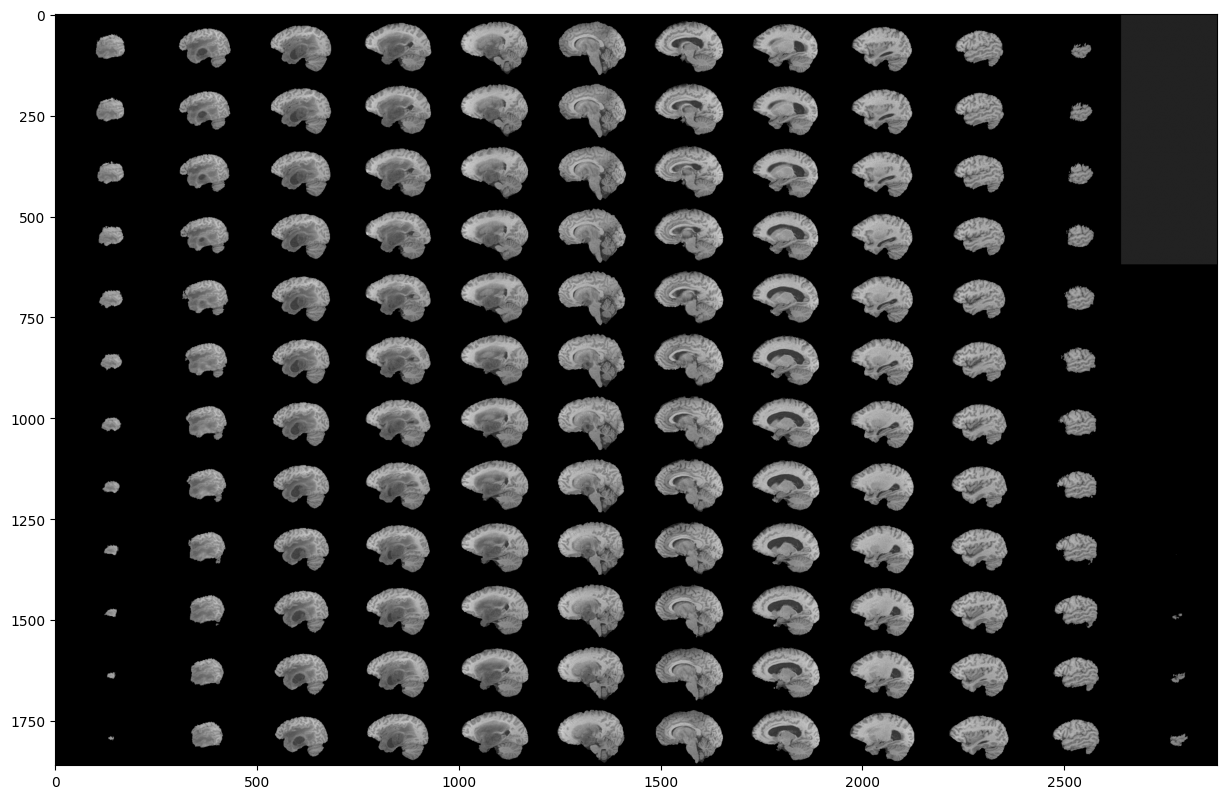

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

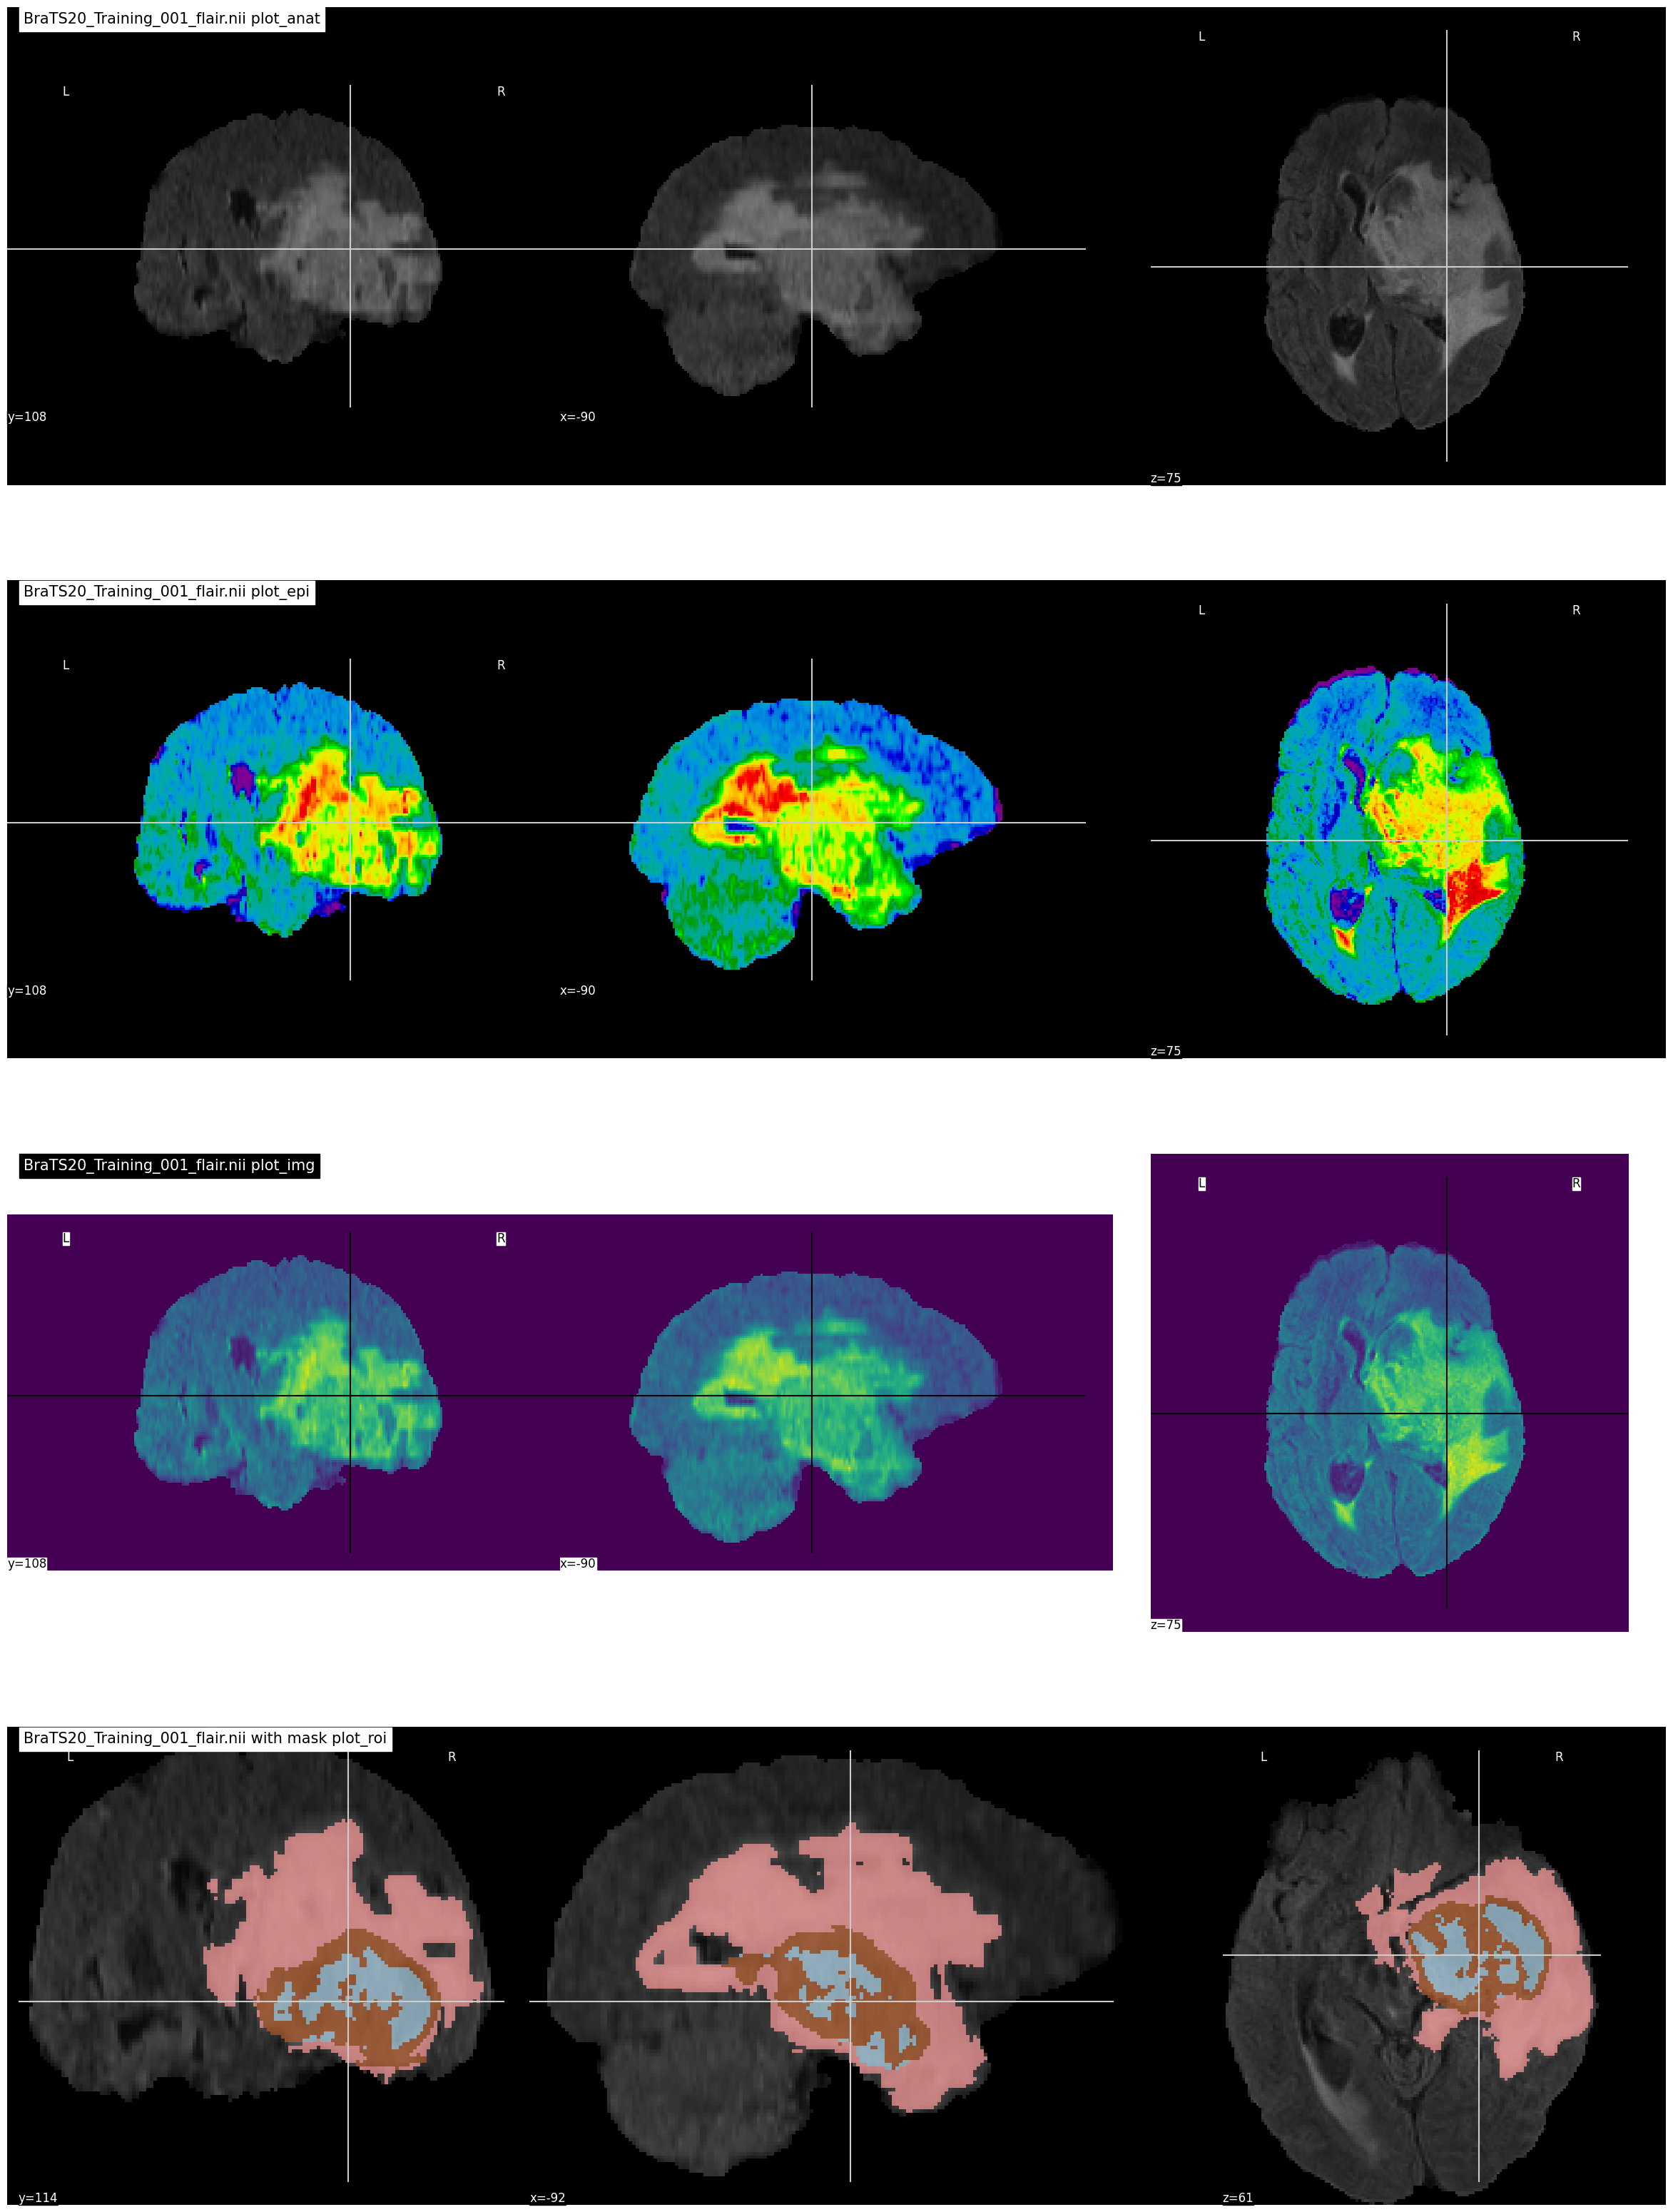

In [ ]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS20_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS20_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS20_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask,
               title='BraTS20_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg,
               axes=axes[3], cmap='Paired')

plt.show()


In [ ]:
IMG_SIZE=128
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    total_dice = 0
    for i in range(class_num):
        y_true_f = tf.reshape(y_true[:,:,:,i], [-1])
        y_pred_f = tf.reshape(y_pred[:,:,:,i], [-1])
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
        total_dice += dice
    return total_dice / class_num

def dice_coef_necrotic(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true[:,:,:,1], [-1])
    y_pred_f = tf.reshape(y_pred[:,:,:,1], [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_coef_edema(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true[:,:,:,2], [-1])
    y_pred_f = tf.reshape(y_pred[:,:,:,2], [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_coef_enhancing(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true[:,:,:,3], [-1])
    y_pred_f = tf.reshape(y_pred[:,:,:,3], [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def precision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def sensitivity(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = tf.reduce_sum(tf.round(tf.clip_by_value((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = tf.reduce_sum(tf.round(tf.clip_by_value(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def combined_loss(y_true, y_pred):
    dice=1-dice_coef(y_true, y_pred)
    crossentropy=tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return 0.5*dice + 0.5*crossentropy



In [ ]:
from tensorflow.keras.layers import Layer, Conv3D, Multiply, Activation, Add

class SpatialAttention(Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size

    def build(self, input_shape):
        self.conv = Conv3D(1, (self.kernel_size, self.kernel_size, self.kernel_size), padding='same', activation='sigmoid', use_bias=False)
        super(SpatialAttention, self).build(input_shape)

    def call(self, inputs):
        attention_map = self.conv(inputs)

        output = Multiply()([inputs, attention_map])

        return output

In [ ]:
from tensorflow.keras.layers import (Input, Conv3D, MaxPooling3D, UpSampling3D,
                                     concatenate, BatchNormalization, Activation, Dropout, SpatialDropout3D)
from tensorflow.keras.models import Model

def build_unet(inputs, ker_init, dropout):
    # Encoder
    conv1 = Conv3D(32, (3, 3, 3), padding='same', kernel_initializer=ker_init)(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv3D(32, (3, 3, 3), padding='same', kernel_initializer=ker_init)(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Dropout(dropout)(conv1)
    conv1 = SpatialAttention()(conv1)

    pool = MaxPooling3D(pool_size=(2, 2, 2))(conv1)
    conv = Conv3D(64, (3, 3, 3), padding='same', kernel_initializer=ker_init)(pool)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = Conv3D(64, (3, 3, 3), padding='same', kernel_initializer=ker_init)(conv)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = Dropout(dropout)(conv)
    conv = SpatialAttention()(conv)

    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv)
    conv2 = Conv3D(128, (3, 3, 3), padding='same', kernel_initializer=ker_init)(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv3D(128, (3, 3, 3), padding='same', kernel_initializer=ker_init)(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Dropout(dropout)(conv2)
    conv2 = SpatialAttention()(conv2)

    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
    conv3 = Conv3D(256, (3, 3, 3), padding='same', kernel_initializer=ker_init)(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv3D(256, (3, 3, 3), padding='same', kernel_initializer=ker_init)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Dropout(dropout)(conv3)
    conv3 = SpatialAttention()(conv3)

    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)
    conv5 = Conv3D(512, (3, 3, 3), padding='same', kernel_initializer=ker_init)(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv3D(512, (3, 3, 3), padding='same', kernel_initializer=ker_init)(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    drop5 = SpatialDropout3D(dropout)(conv5)

    # Decoder
    up7 = Conv3D(256, (2, 2, 2), padding='same', kernel_initializer=ker_init)(UpSampling3D(size=(2, 2, 2))(drop5))
    up7 = BatchNormalization()(up7)
    up7 = Activation('relu')(up7)
    merge7 = concatenate([conv3, up7])
    conv7 = Conv3D(256, (3, 3, 3), padding='same', kernel_initializer=ker_init)(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv3D(256, (3, 3, 3), padding='same', kernel_initializer=ker_init)(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Dropout(dropout)(conv7)
    conv7 = SpatialAttention()(conv7)

    up8 = Conv3D(128, (2, 2, 2), padding='same', kernel_initializer=ker_init)(UpSampling3D(size=(2, 2, 2))(conv7))
    up8 = BatchNormalization()(up8)
    up8 = Activation('relu')(up8)
    merge8 = concatenate([conv2, up8])
    conv8 = Conv3D(128, (3, 3, 3), padding='same', kernel_initializer=ker_init)(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv3D(128, (3, 3, 3), padding='same', kernel_initializer=ker_init)(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Dropout(dropout)(conv8)
    conv8 = SpatialAttention()(conv8)

    up9 = Conv3D(64, (2, 2, 2), padding='same', kernel_initializer=ker_init)(UpSampling3D(size=(2, 2, 2))(conv8))
    up9 = BatchNormalization()(up9)
    up9 = Activation('relu')(up9)
    merge9 = concatenate([conv, up9])
    conv9 = Conv3D(64, (3, 3, 3), padding='same', kernel_initializer=ker_init)(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv3D(64, (3, 3, 3), padding='same', kernel_initializer=ker_init)(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Dropout(dropout)(conv9)
    conv9 = SpatialAttention()(conv9)

    up = Conv3D(32, (2, 2, 2), padding='same', kernel_initializer=ker_init)(UpSampling3D(size=(2, 2, 2))(conv9))
    up = BatchNormalization()(up)
    up = Activation('relu')(up)
    merge = concatenate([conv1, up])
    conv = Conv3D(32, (3, 3, 3), padding='same', kernel_initializer=ker_init)(merge)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = Conv3D(32, (3, 3, 3), padding='same', kernel_initializer=ker_init)(conv)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = Dropout(dropout)(conv)

    conv10 = Conv3D(4, (1, 1, 1), activation='softmax')(conv)

    return Model(inputs=inputs, outputs=conv10)


In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    # Compute dice coefficient for each class
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])  # Sum over spatial dimensions
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])

    dice = (2. * intersection + smooth) / (union + smooth)  # Dice coefficient per class
    return dice

def combined_loss(y_true, y_pred):
    # Compute categorical crossentropy loss for each pixel
    crossentropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

    # Calculate dice coefficient per class
    dice = dice_coefficient(y_true, y_pred)  # This function needs to handle the class-wise dice coefficient calculation

    # Average both losses (or use weighted sum if preferred)
    return tf.reduce_mean(crossentropy) + tf.reduce_mean(dice)




input_layer = Input((IMG_SIZE, IMG_SIZE, IMG_SIZE, 3))
model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(
    loss=combined_loss,
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)


In [ ]:
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);


train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [ ]:
import numpy as np
import tensorflow as tf
import keras
import cv2
import nibabel as nib
import os

class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, batch_size=1, dim=(240, 240, 50),
                 n_channels=3, shuffle=True, data_path=''):
        """Initialize DataGenerator.

        Args:
            list_IDs: List of sample IDs
            batch_size: Size of each batch
            dim: Dimensions of input image
            n_channels: Number of input channels
            shuffle: Whether to shuffle data between epochs
            data_path: Base path to dataset
        """
        super().__init__()
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.data_path = data_path
        self.on_epoch_end()

    def on_epoch_end(self):
        """Updates indexes after each epoch."""
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        """Returns the number of batches per epoch."""
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data."""
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]


        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def __data_generation(self, batch_ids):
        """Generates data containing batch_size samples."""
        X = np.zeros((self.batch_size, *self.dim, self.n_channels), dtype=np.float32)
        y = np.zeros((self.batch_size, *self.dim, 4), dtype=np.float32)

        for c, ID in enumerate(batch_ids):
            case_path = os.path.join(self.data_path, ID)

            flair = nib.load(os.path.join(case_path, f'{ID}_flair.nii')).get_fdata()
            t1ce = nib.load(os.path.join(case_path, f'{ID}_t1ce.nii')).get_fdata()
            t1 = nib.load(os.path.join(case_path, f'{ID}_t1.nii')).get_fdata()
            seg = nib.load(os.path.join(case_path, f'{ID}_seg.nii')).get_fdata()

            for j in range(self.dim[2]):  # Assuming dim[2] is the number of slices
                X[c, :, :, j, 0] = cv2.resize(flair[:, :, j], (self.dim[0], self.dim[1]))
                X[c, :, :, j, 1] = cv2.resize(t1ce[:, :, j], (self.dim[0], self.dim[1]))
                X[c, :, :, j, 2] = cv2.resize(t1[:, :, j], (self.dim[0], self.dim[1]))

                # Handle segmentation mask
                temp_seg = cv2.resize(seg[:, :, j], (self.dim[0], self.dim[1]),
                                   interpolation=cv2.INTER_NEAREST)
                temp_seg[temp_seg == 4] = 3  # Convert label 4 to 3
                mask = tf.cast(tf.one_hot(temp_seg.astype(np.int32), 4), tf.float32)
                y[c, :, :, j] = mask

        # Normalize input
        X = X / np.max(X)

        return X, y

#training_generator = DataGenerator(train_ids)
#valid_generator = DataGenerator(val_ids)
#test_generator = DataGenerator(test_ids)

In [ ]:
callbacks = [
    # Uncomment if needed
    # keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
    #                               patience=2, verbose=1, mode='auto'),
     keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                               patience=2, min_lr=0.000001, verbose=1),
    # keras.callbacks.ModelCheckpoint(filepath='model_.{epoch:02d}-{val_loss:.6f}.weights.h5',
     #                               verbose=1, save_best_only=True, save_weights_only=True)
]


In [ ]:
import tensorflow as tf

strategy = tf.distribute.MirroredStrategy()
print(f'Number of devices: {strategy.num_replicas_in_sync}')

with strategy.scope():
    input_layer = Input((IMG_SIZE, IMG_SIZE, IMG_SIZE, 3))
    model = build_unet(input_layer, 'he_normal', 0.2)
    model.compile(
        loss=combined_loss,
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
        metrics=[
            'accuracy',
            tf.keras.metrics.MeanIoU(num_classes=4),
            dice_coef,
            precision,
            sensitivity,
            specificity,
            dice_coef_necrotic,
            dice_coef_edema,
            dice_coef_enhancing
        ]
    )


BATCH_SIZE_PER_GPU = 1
global_batch_size = BATCH_SIZE_PER_GPU * strategy.num_replicas_in_sync

training_generator = DataGenerator(
    list_IDs=train_ids,
    batch_size=global_batch_size,
    dim=(IMG_SIZE, IMG_SIZE, IMG_SIZE),
    n_channels=3,
    data_path=TRAIN_DATASET_PATH
)

valid_generator = DataGenerator(
    list_IDs=val_ids,
    batch_size=global_batch_size,
    dim=(IMG_SIZE, IMG_SIZE, IMG_SIZE),
    n_channels=3,
    data_path=TRAIN_DATASET_PATH
)

test_generator = DataGenerator(
    list_IDs=test_ids,
    batch_size=global_batch_size,
    dim=(IMG_SIZE, IMG_SIZE, IMG_SIZE),
    n_channels=3,
    data_path=VALIDATION_DATASET_PATH
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    training_generator,
    epochs=5,
    callbacks=[early_stopping],
    validation_data=valid_generator
)

Number of devices: 1
Epoch 1/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 942s 4s/step - accuracy: 0.8532 - dice_coef: 0.5161 - dice_coef_edema: 0.5347 - dice_coef_enhancing: 0.5368 - dice_coef_necrotic: 0.5408 - loss: 0.9740 - mean_io_u_2: 0.3750 - precision: 0.8183 - sensitivity: 0.5884 - specificity: 0.9867 - val_accuracy: 0.9857 - val_dice_coef: 0.6132 - val_dice_coef_edema: 0.6269 - val_dice_coef_enhancing: 0.6563 - val_dice_coef_necrotic: 0.6075 - val_loss: 0.6975 - val_mean_io_u_2: 0.3750 - val_precision: 0.9980 - val_sensitivity: 0.8611 - val_specificity: 0.9994
Epoch 2/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 870s 3s/step - accuracy: 0.9770 - dice_coef: 0.7496 - dice_coef_edema: 0.7563 - dice_coef_enhancing: 0.7675 - dice_coef_necrotic: 0.7392 - loss: 0.5689 - mean_io_u_2: 0.3750 - precision: 0.9911 - sensitivity: 0.9455 - specificity: 0.9972 - val_accuracy: 0.9855 - val_dice_coef: 0.8532 - val_dice_coef_edema: 0.8650 - val_dice_coef_enhancing: 0.8684 - val_dice_coef_necrotic: 0.8540 - val_loss: 0.45

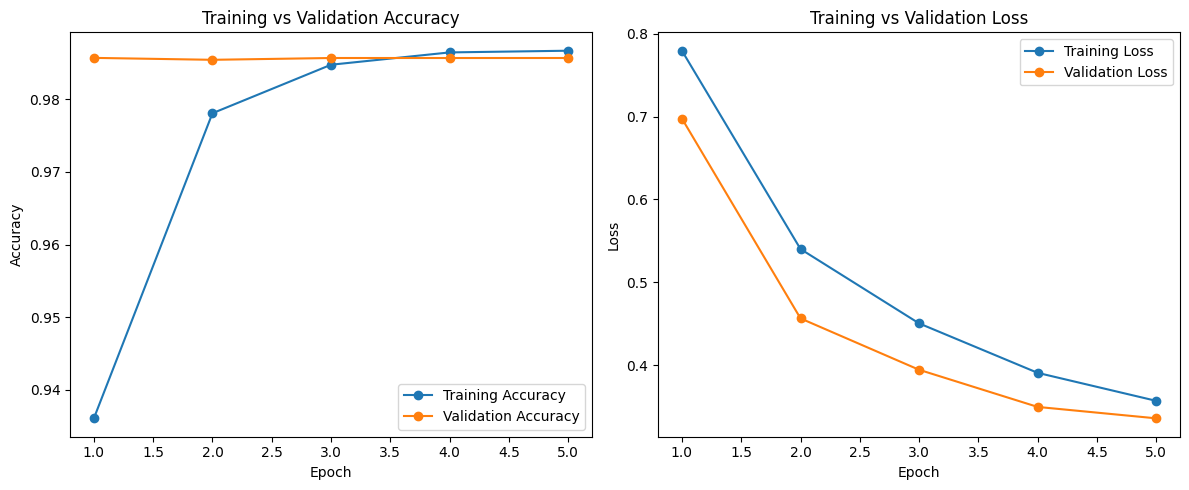

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()



Case BraTS20_Training_160
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


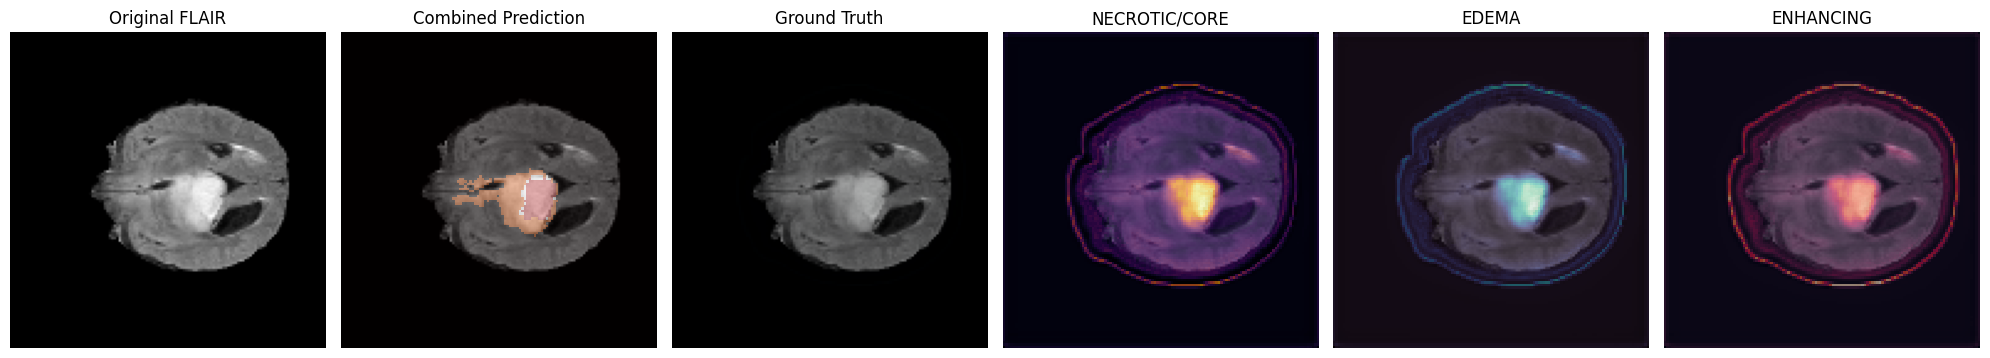


Dice Scores for slice 64:
Necrotic/Core: 0.000
Edema: 0.000
Enhancing: 1.000
Average: 0.333

Case BraTS20_Training_167
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step


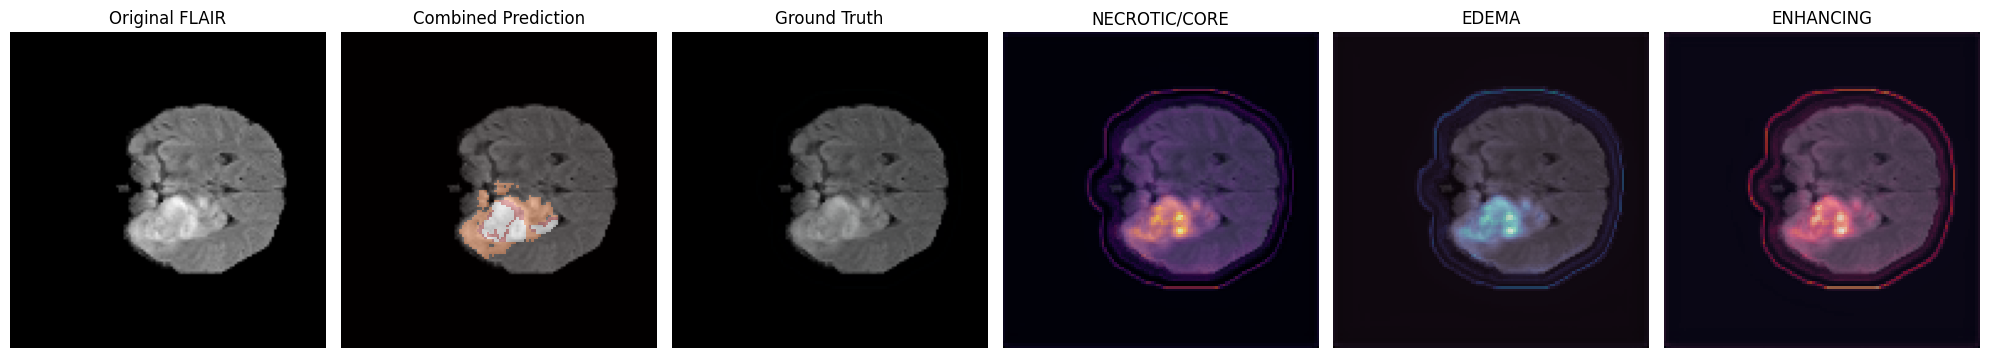


Dice Scores for slice 64:
Necrotic/Core: 0.000
Edema: 0.000
Enhancing: 1.000
Average: 0.333

Case BraTS20_Training_118
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step


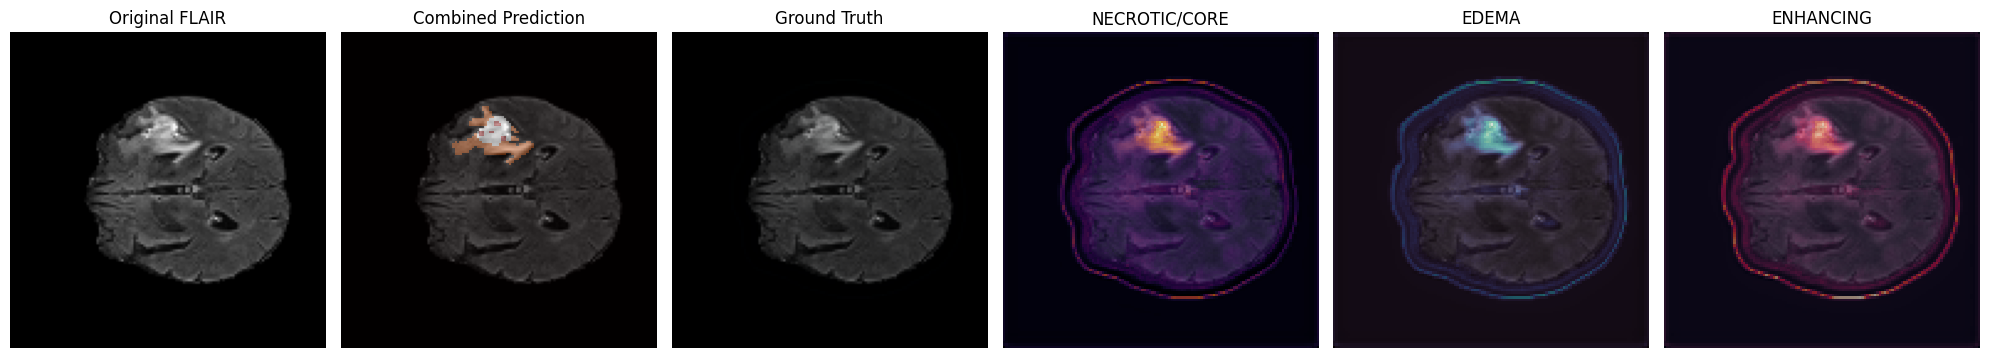


Dice Scores for slice 64:
Necrotic/Core: 0.000
Edema: 0.000
Enhancing: 1.000
Average: 0.333

Case BraTS20_Training_179
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


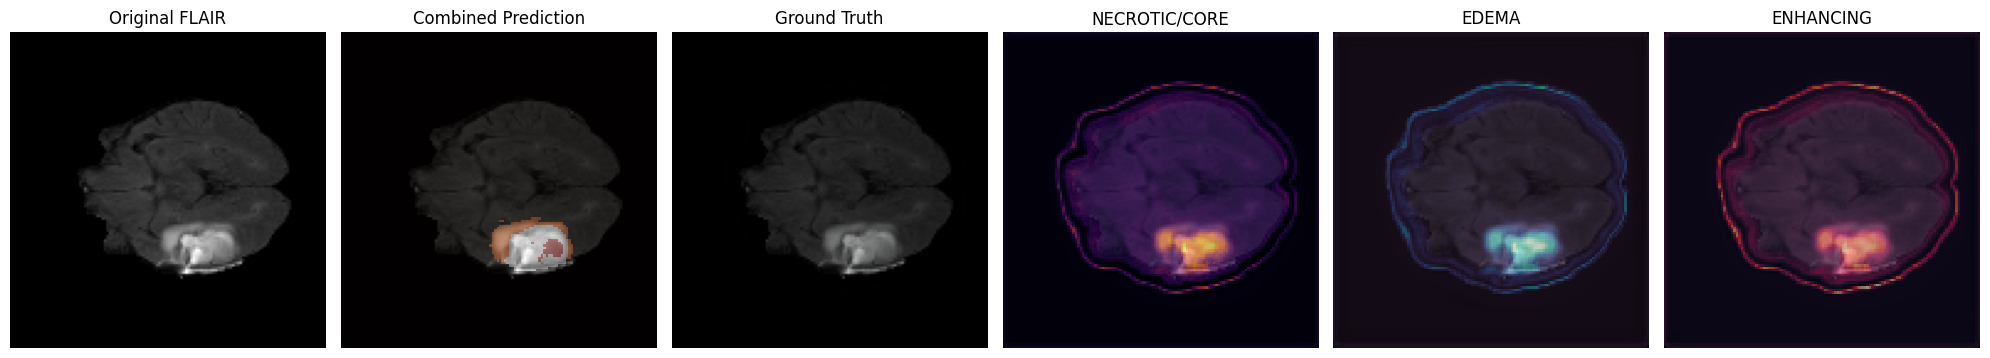


Dice Scores for slice 64:
Necrotic/Core: 0.000
Edema: 0.000
Enhancing: 1.000
Average: 0.333

Case BraTS20_Training_121
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


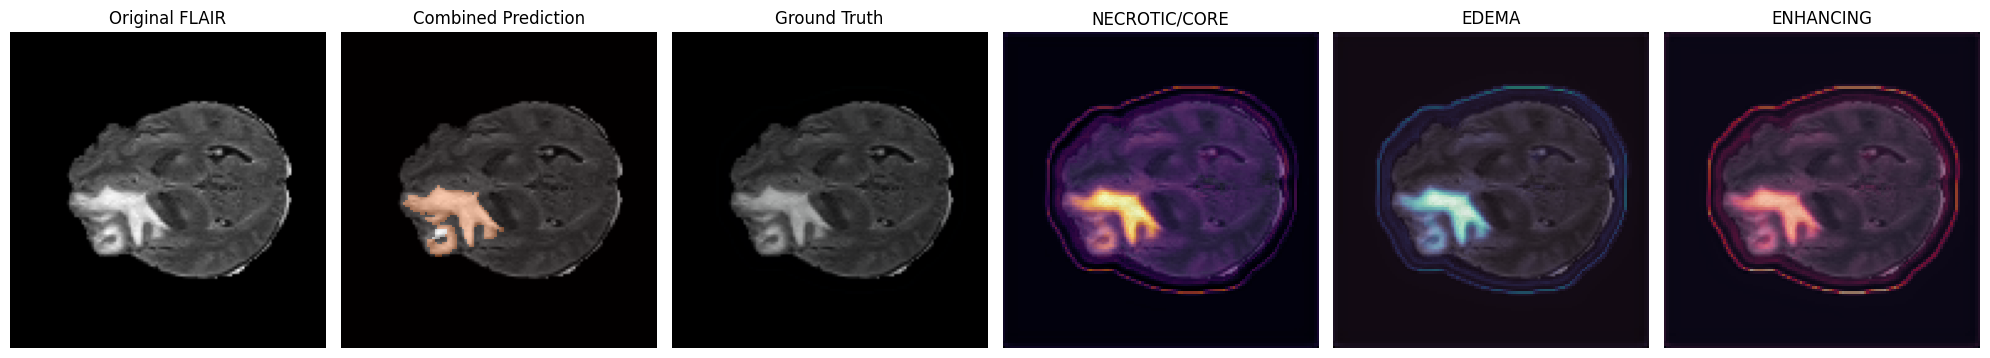


Dice Scores for slice 64:
Necrotic/Core: 1.000
Edema: 0.000
Enhancing: 1.000
Average: 0.667
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


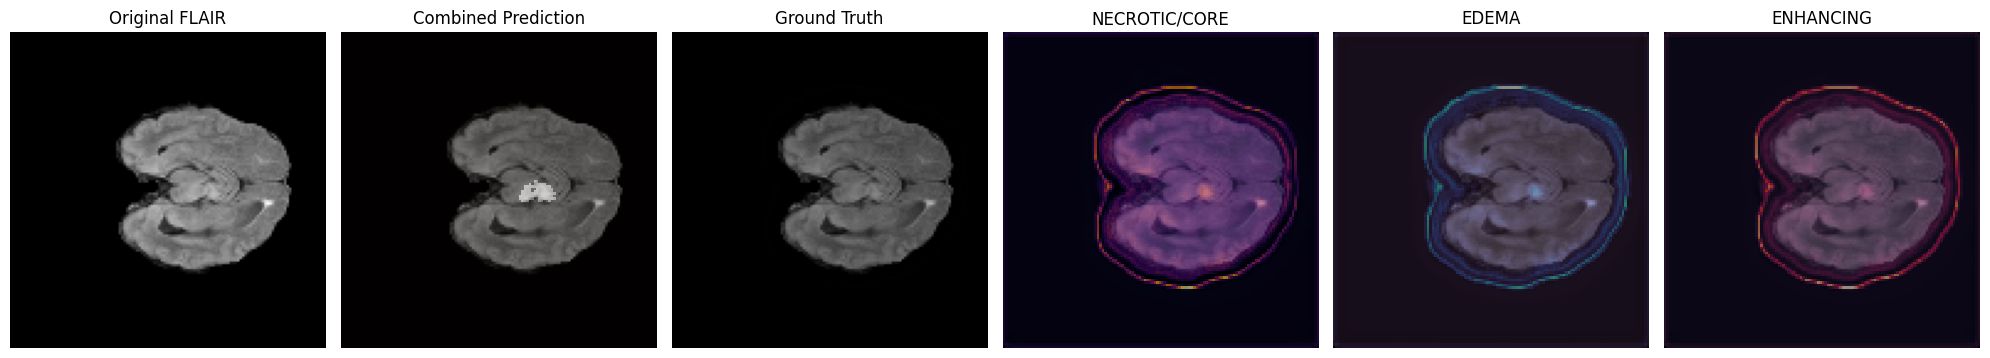


Dice Scores for slice 50:
Necrotic/Core: 1.000
Edema: 0.000
Enhancing: 1.000
Average: 0.667
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


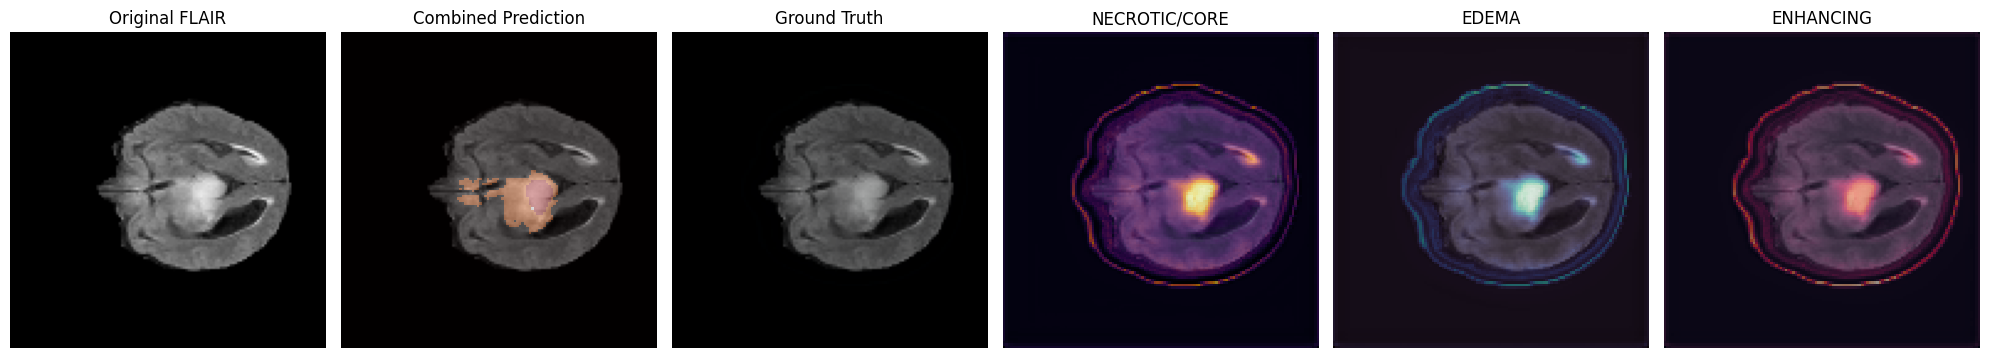


Dice Scores for slice 60:
Necrotic/Core: 0.000
Edema: 0.000
Enhancing: 1.000
Average: 0.333
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step


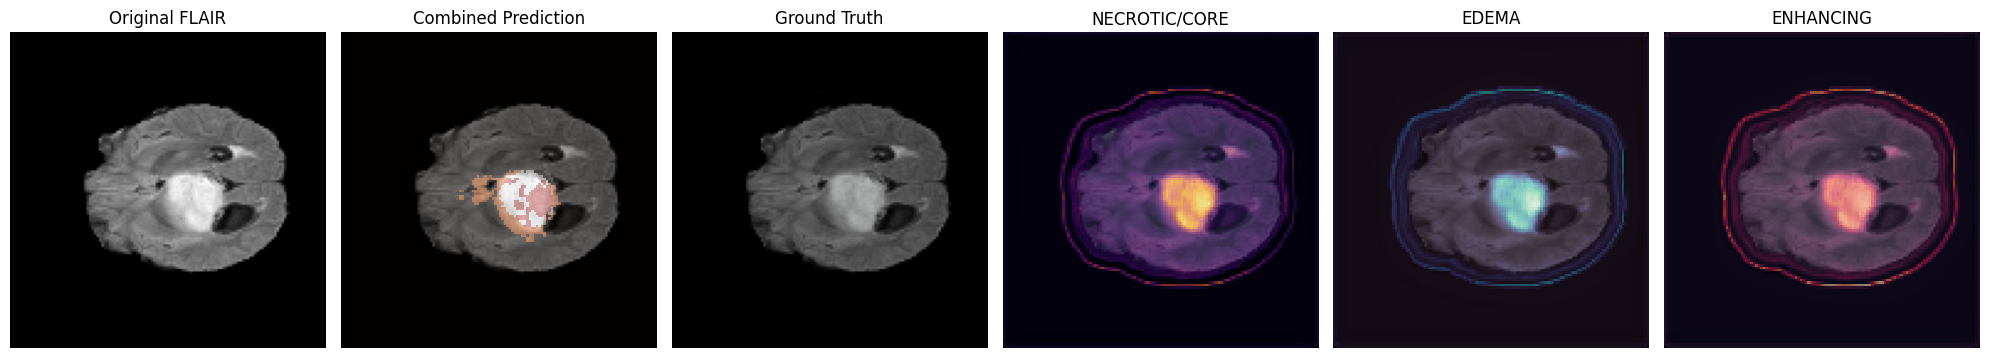


Dice Scores for slice 70:
Necrotic/Core: 0.000
Edema: 0.000
Enhancing: 1.000
Average: 0.333
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step


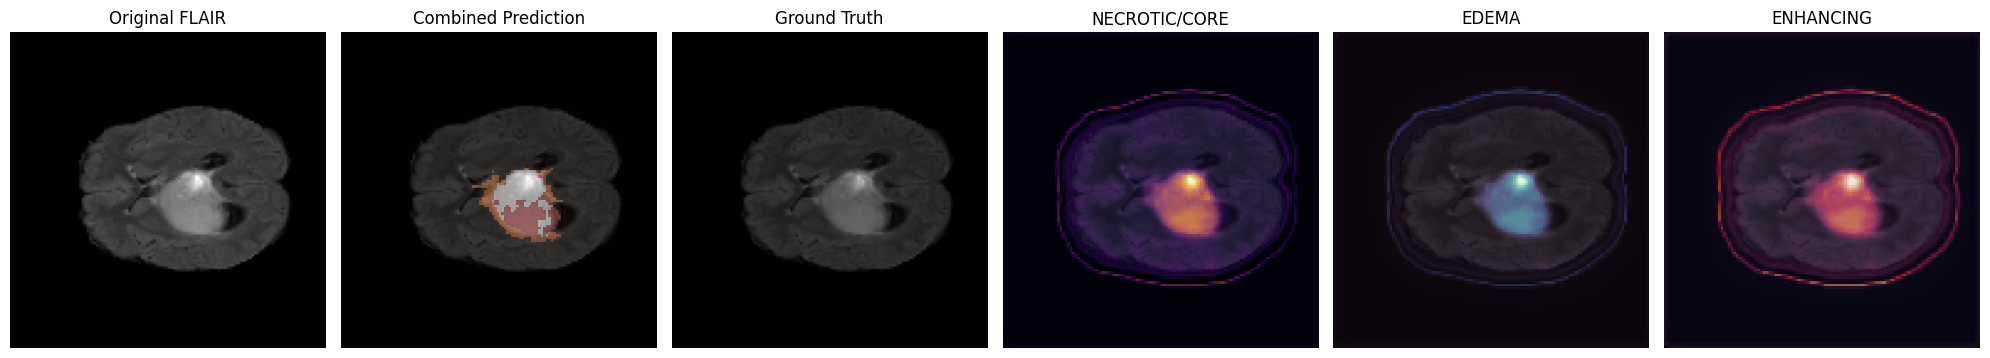


Dice Scores for slice 80:
Necrotic/Core: 0.000
Edema: 0.000
Enhancing: 1.000
Average: 0.333


In [ ]:
import tensorflow as tf
strategy = tf.distribute.MirroredStrategy()

import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import cv2
import os

# ------------------ Prediction Function ------------------
def predictByPath(model, case_path, case_id):
    X = np.zeros((1, IMG_SIZE, IMG_SIZE, IMG_SIZE, 3))  # 5D Tensor for prediction

    flair = nib.load(os.path.join(case_path, f'{case_id}_flair.nii')).get_fdata()
    t1ce = nib.load(os.path.join(case_path, f'{case_id}_t1ce.nii')).get_fdata()
    t1 = nib.load(os.path.join(case_path, f'{case_id}_t1.nii')).get_fdata()

    for j in range(IMG_SIZE):
        X[0, :, :, j, 0] = cv2.resize(flair[:, :, j], (IMG_SIZE, IMG_SIZE))
        X[0, :, :, j, 1] = cv2.resize(t1ce[:, :, j], (IMG_SIZE, IMG_SIZE))
        X[0, :, :, j, 2] = cv2.resize(t1[:, :, j], (IMG_SIZE, IMG_SIZE))

    X = X / np.max(X)  # Normalize

    return model.predict(X, verbose=1)

# ------------------ Visualization and Dice Score Function ------------------
def showPredictsById(model, case_id, data_path, start_slice=64):
    case_path = os.path.join(data_path, case_id)

    gt = nib.load(os.path.join(case_path, f'{case_id}_seg.nii')).get_fdata()
    flair = nib.load(os.path.join(case_path, f'{case_id}_flair.nii')).get_fdata()

    predictions = predictByPath(model, case_path, case_id)

    # Split the predictions into classes
    background = predictions[0, :, :, :, 0]
    necrotic = predictions[0, :, :, :, 1]
    edema = predictions[0, :, :, :, 2]
    enhancing = predictions[0, :, :, :, 3]

    plt.figure(figsize=(20, 4))

    # Plot Original FLAIR
    plt.subplot(161)
    plt.imshow(cv2.resize(flair[:, :, start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    plt.title('Original FLAIR')
    plt.axis('off')

    # Plot Ground Truth Segmentation
    plt.subplot(162)
    gt_slice = cv2.resize(gt[:, :, start_slice], (IMG_SIZE, IMG_SIZE),
                          interpolation=cv2.INTER_NEAREST)
    plt.imshow(cv2.resize(flair[:, :, start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    plt.imshow(gt_slice, cmap="hot", interpolation='none', alpha=0.3)
    plt.title('Combined Prediction')
    plt.axis('off')

    # Plot Combined Prediction
    plt.subplot(163)
    combined_pred = np.zeros((IMG_SIZE, IMG_SIZE, 3))
    combined_pred[:, :, 0] = necrotic[:, :, start_slice]
    combined_pred[:, :, 1] = edema[:, :, start_slice]
    combined_pred[:, :, 2] = enhancing[:, :, start_slice]
    plt.imshow(cv2.resize(flair[:, :, start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    plt.imshow(combined_pred, interpolation='none', alpha=0.3)
    plt.title('Ground Truth')
    plt.axis('off')

    # Plot each class separately
    plt.subplot(164)
    plt.imshow(cv2.resize(flair[:, :, start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    plt.imshow(necrotic[:, :, start_slice], cmap="inferno", interpolation='none', alpha=0.6)
    plt.title(f'{SEGMENT_CLASSES[1]}')
    plt.axis('off')

    necrotic_mask = necrotic[:, :, start_slice] > 0.5  # Threshold to highlight necrotic
    plt.contour(necrotic_mask, colors='yellow', linewidths=1)

    plt.subplot(165)
    plt.imshow(cv2.resize(flair[:, :, start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    plt.imshow(edema[:, :, start_slice], cmap="mako", interpolation='none', alpha=0.6)  # Increased alpha for edema
    plt.title(f'{SEGMENT_CLASSES[2]}')
    plt.axis('off')

# Apply a threshold to the edema region to create a binary mask
    edema_mask = edema[:, :, start_slice] > 0.5  # Threshold to highlight edema
    plt.contour(edema_mask, colors='cyan', linewidths=1)

    plt.subplot(166)
    plt.imshow(cv2.resize(flair[:, :, start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    plt.imshow(enhancing[:, :, start_slice], cmap="rocket", interpolation='none', alpha=0.6)  # Increased alpha for enhancing
    plt.title(f'{SEGMENT_CLASSES[3]}')
    plt.axis('off')

# Apply a threshold to the enhancing region to create a binary mask
    enhancing_mask = enhancing[:, :, start_slice] > 0.5  # Threshold to highlight enhancing
    plt.contour(enhancing_mask, colors='green', linewidths=1)

    plt.tight_layout()
    plt.show()

    # --------- Calculate Dice Scores ------------
    dice_scores = []
    gt_slice = gt_slice.astype(int)
    pred_slice = np.argmax(predictions[0, :, :, start_slice], axis=-1)

    for i in range(1, 4):  # classes 1 to 3
        gt_binary = (gt_slice == i).astype(np.float32)
        pred_binary = (pred_slice == i).astype(np.float32)
        intersection = np.sum(gt_binary * pred_binary)
        union = np.sum(gt_binary) + np.sum(pred_binary)
        if union > 0:
            dice = 2 * intersection / union
        else:
            dice = 1.0 if intersection == 0 else 0.0
        dice_scores.append(dice)

    print("\nDice Scores for slice {}:".format(start_slice))
    print(f"Necrotic/Core: {dice_scores[0]:.3f}")
    print(f"Edema: {dice_scores[1]:.3f}")
    print(f"Enhancing: {dice_scores[2]:.3f}")
    print(f"Average: {np.mean(dice_scores):.3f}")

# ------------------ Prediction and Visualization for Multiple Cases ------------------
# Predict and plot for first 5 test cases
for i in range(5):
    print(f"\nCase {test_ids[i]}")
    showPredictsById(model, test_ids[i], TRAIN_DATASET_PATH)

# Predict and plot different slices for one specific case
case_id = test_ids[0]
for slice_idx in [50, 60, 70, 80]:  # View slices 50, 60, 70, 80
    showPredictsById(model, case_id, TRAIN_DATASET_PATH, start_slice=slice_idx)


In [ ]:
model.save('3d_attention_unet.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


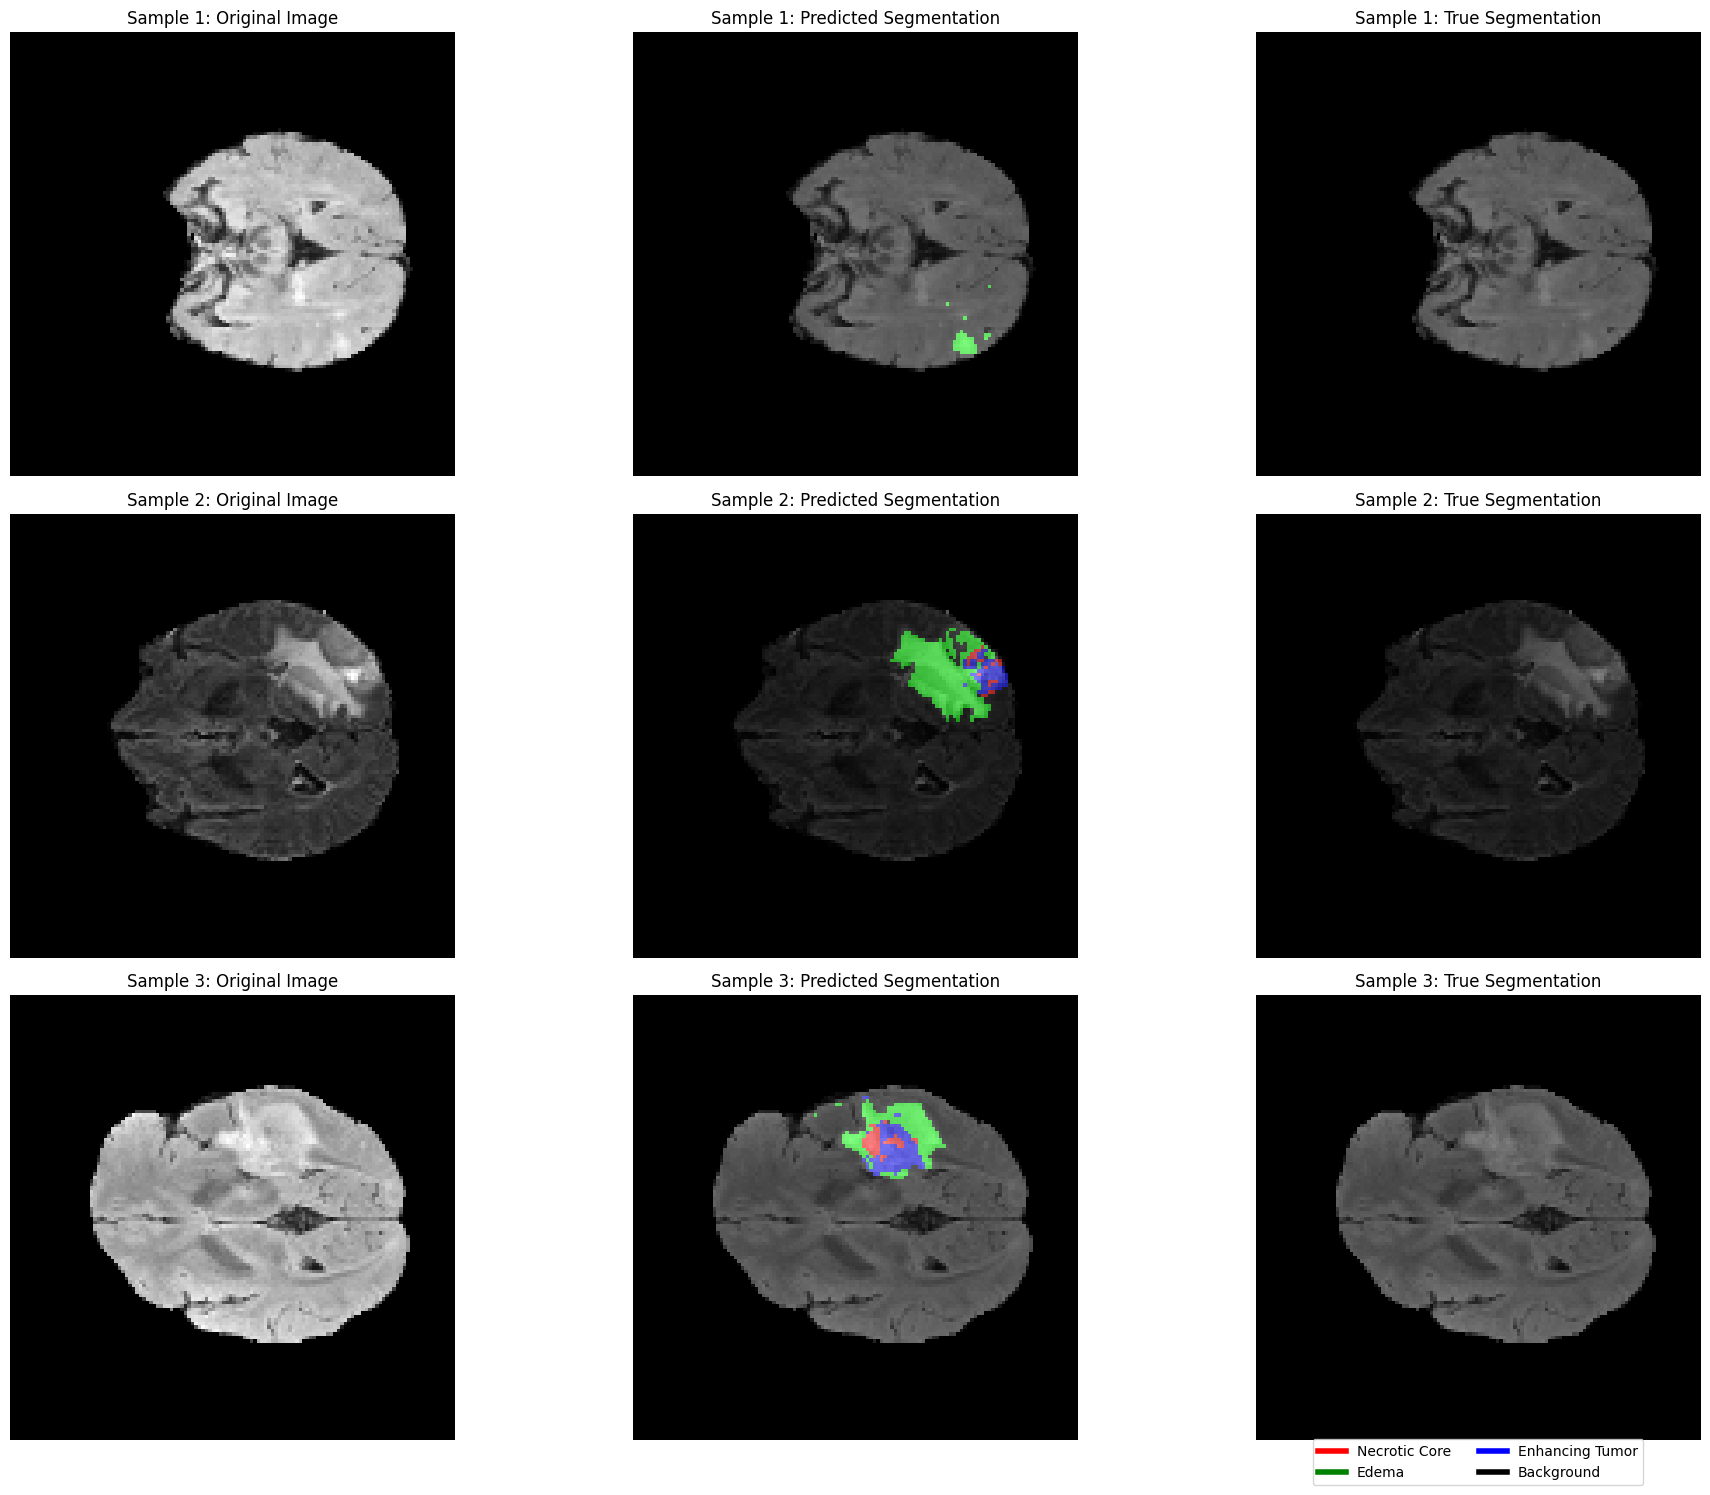

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import cv2

def visualize_predictions(model, test_generator, num_samples=3):
    """
    Visualize model predictions for brain tumor segmentation
    """
    plt.figure(figsize=(20, 5*num_samples))

    segment_classes = {
        0: 'Background',
        1: 'Necrotic Core',
        2: 'Edema',
        3: 'Enhancing Tumor'
    }

    colors = {
        0: [0, 0, 0],       # Black
        1: [255, 0, 0],        # Red
        2: [0, 255, 0],        # Green
        3: [0, 0, 255]         # Blue
    }

    for sample in range(num_samples):
        # Get a batch from test generator
        X_batch, batch_y_true = test_generator[sample]

        # Predict segmentation
        batch_y_pred = model.predict(X_batch)

        # Select first image in batch
        X = X_batch[0]
        y_true = batch_y_true[0]
        y_pred = batch_y_pred[0]

        # Argmax to get class predictions
        y_true_classes = np.argmax(y_true, axis=-1)
        y_pred_classes = np.argmax(y_pred, axis=-1)

        # Create overlay images
        middle_slice = X.shape[2] // 2

        # Original image (using first channel)
        original_img = X[:,:,middle_slice,0]

        # Normalize original image
        original_img = (original_img - original_img.min()) / (original_img.max() - original_img.min())

        # Create RGB overlay images for both true and predicted segmentation
        pred_overlay = np.zeros((original_img.shape[0], original_img.shape[1], 3))
        true_overlay = np.zeros((original_img.shape[0], original_img.shape[1], 3))

        # Apply the same color mapping for both true and predicted segmentations
        for cls in range(1, 4):  # Skip background (cls=0)
            pred_mask = (y_pred_classes[:,:,middle_slice] == cls)
            true_mask = (y_true_classes[:,:,middle_slice] == cls)

            # Assign color to the masks
            for color_channel in range(3):
                pred_overlay[pred_mask, color_channel] = colors[cls][color_channel]
                true_overlay[true_mask, color_channel] = colors[cls][color_channel]

        # Plot results
        plt.subplot(num_samples, 3, sample*3 + 1)
        plt.title(f'Sample {sample+1}: Original Image')
        plt.imshow(original_img, cmap='gray')
        plt.axis('off')

        plt.subplot(num_samples, 3, sample*3 + 2)
        plt.title(f'Sample {sample+1}: Predicted Segmentation')
        plt.imshow(original_img, cmap='gray')
        plt.imshow(true_overlay, alpha=0.5)  # Overlay true segmentation with alpha blending
        plt.axis('off')

        plt.subplot(num_samples, 3, sample*3 + 3)
        plt.title(f'Sample {sample+1}: True Segmentation')
        plt.imshow(original_img, cmap='gray')
        plt.imshow(pred_overlay, alpha=0.5)  # Overlay predicted segmentation with alpha blending
        plt.axis('off')

    # Add a legend for color mapping
    handles = [
        plt.Line2D([0], [0], color='red', lw=4, label='Necrotic Core'),
        plt.Line2D([0], [0], color='green', lw=4, label='Edema'),
        plt.Line2D([0], [0], color='blue', lw=4, label='Enhancing Tumor'),
        plt.Line2D([0], [0], color='black', lw=4, label='Background')
    ]
    plt.legend(handles=handles, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=2)

    plt.tight_layout()
    plt.show()

# Usage
visualize_predictions(model, training_generator)



Case BraTS20_Training_160
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


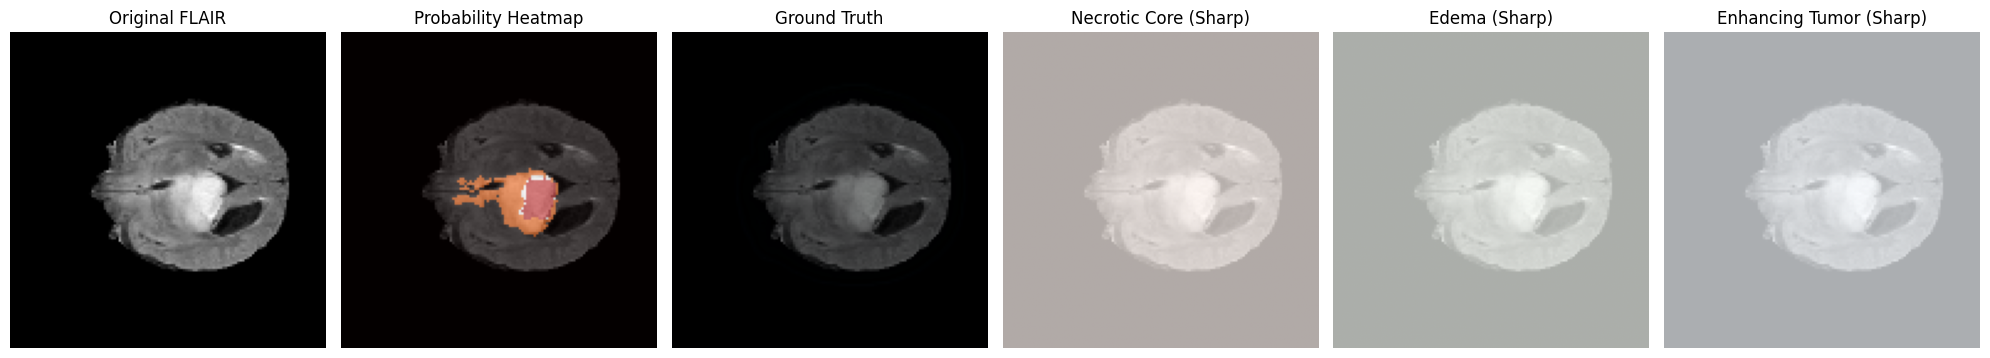


Dice Scores for slice 64:
Necrotic/Core: 0.000
Edema: 0.000
Enhancing: 1.000
Average: 0.333

Case BraTS20_Training_167
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step


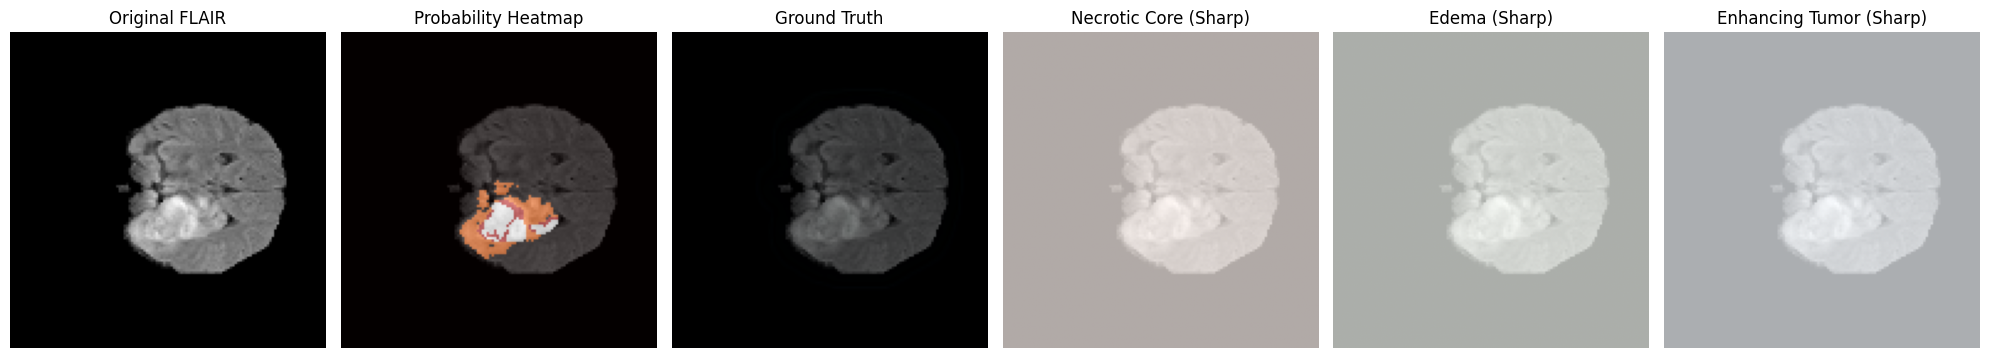


Dice Scores for slice 64:
Necrotic/Core: 0.000
Edema: 0.000
Enhancing: 1.000
Average: 0.333

Case BraTS20_Training_118
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


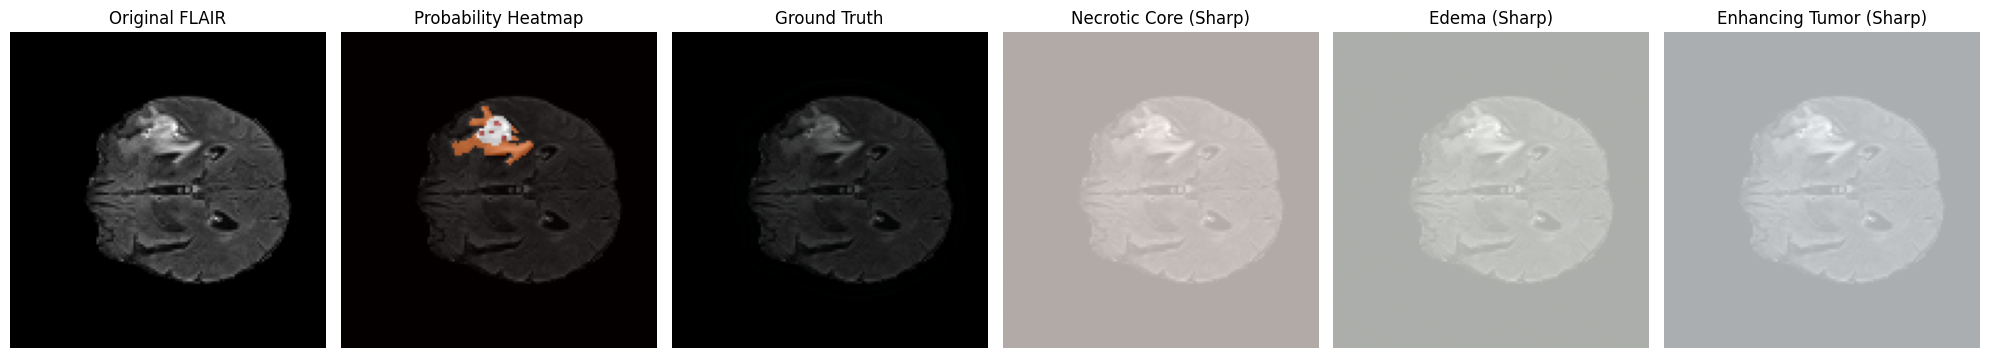


Dice Scores for slice 64:
Necrotic/Core: 0.000
Edema: 0.000
Enhancing: 1.000
Average: 0.333

Case BraTS20_Training_179
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


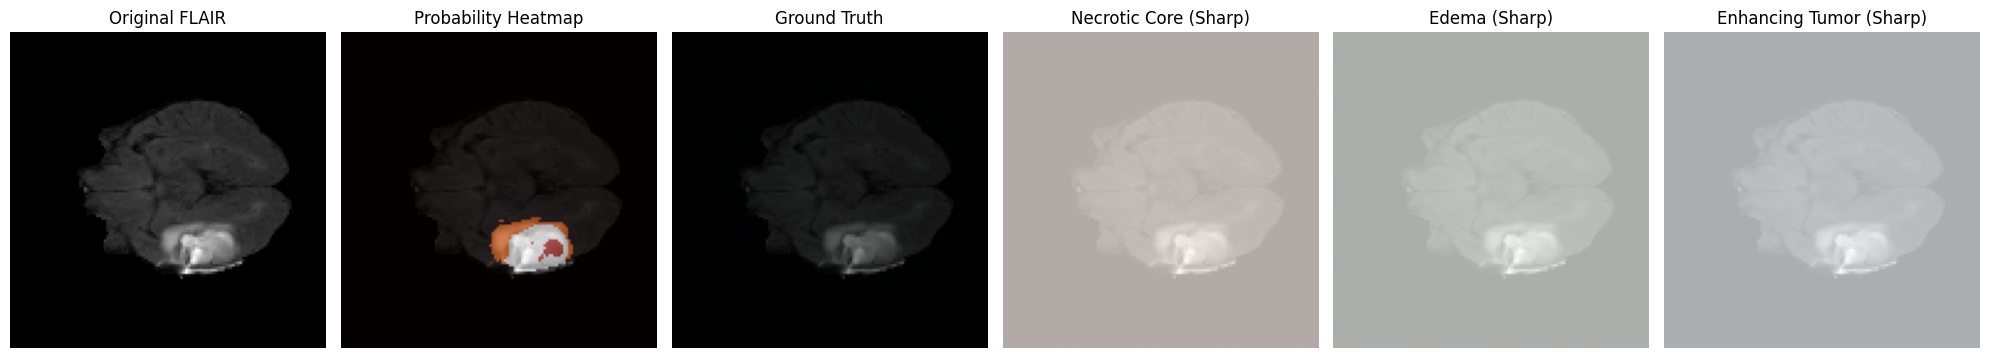


Dice Scores for slice 64:
Necrotic/Core: 0.000
Edema: 0.000
Enhancing: 1.000
Average: 0.333

Case BraTS20_Training_121
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


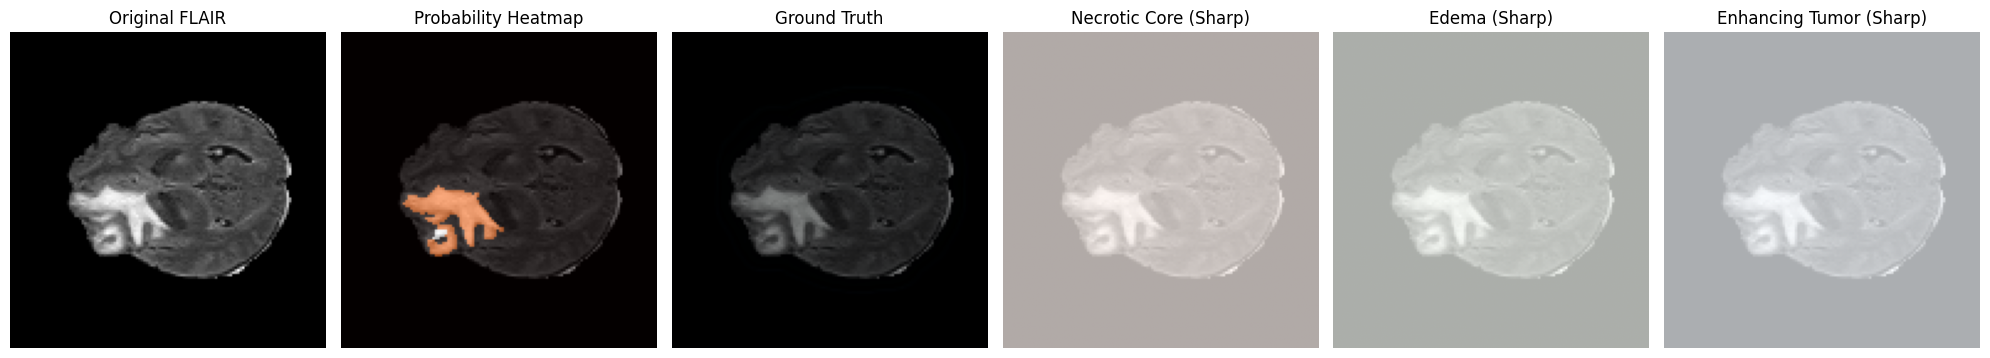


Dice Scores for slice 64:
Necrotic/Core: 1.000
Edema: 0.000
Enhancing: 1.000
Average: 0.667
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


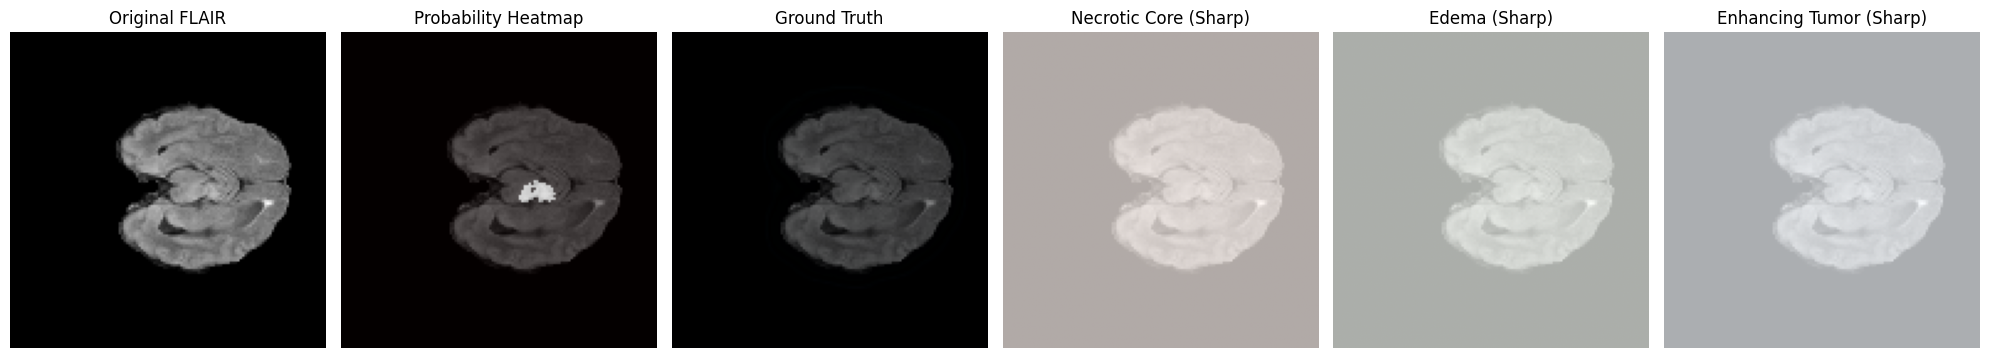


Dice Scores for slice 50:
Necrotic/Core: 1.000
Edema: 0.000
Enhancing: 1.000
Average: 0.667
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


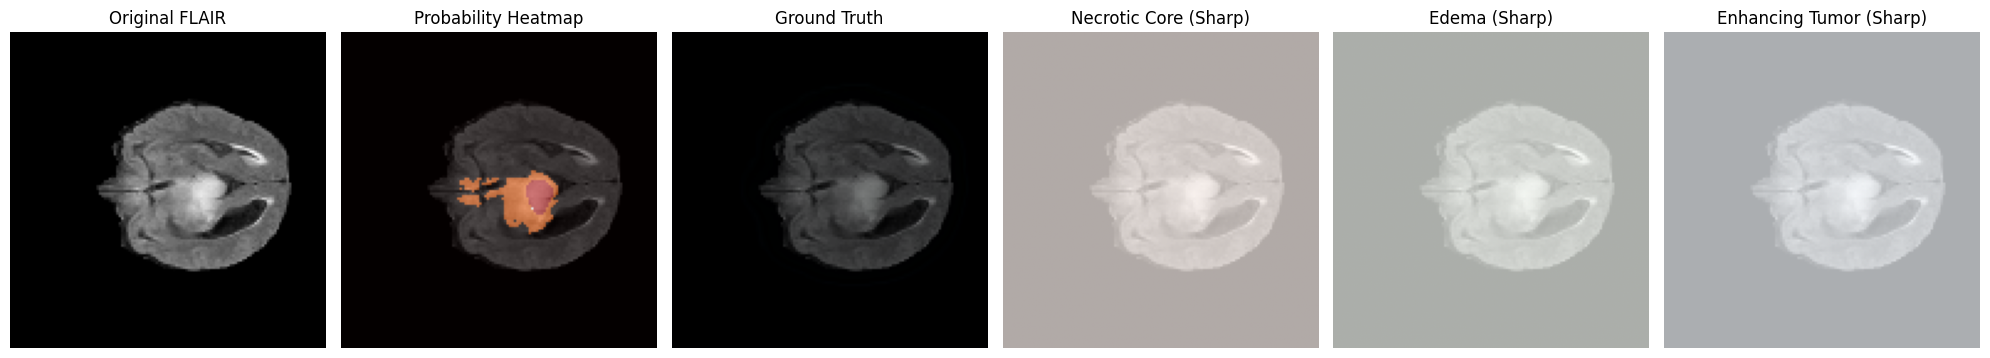


Dice Scores for slice 60:
Necrotic/Core: 0.000
Edema: 0.000
Enhancing: 1.000
Average: 0.333
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step


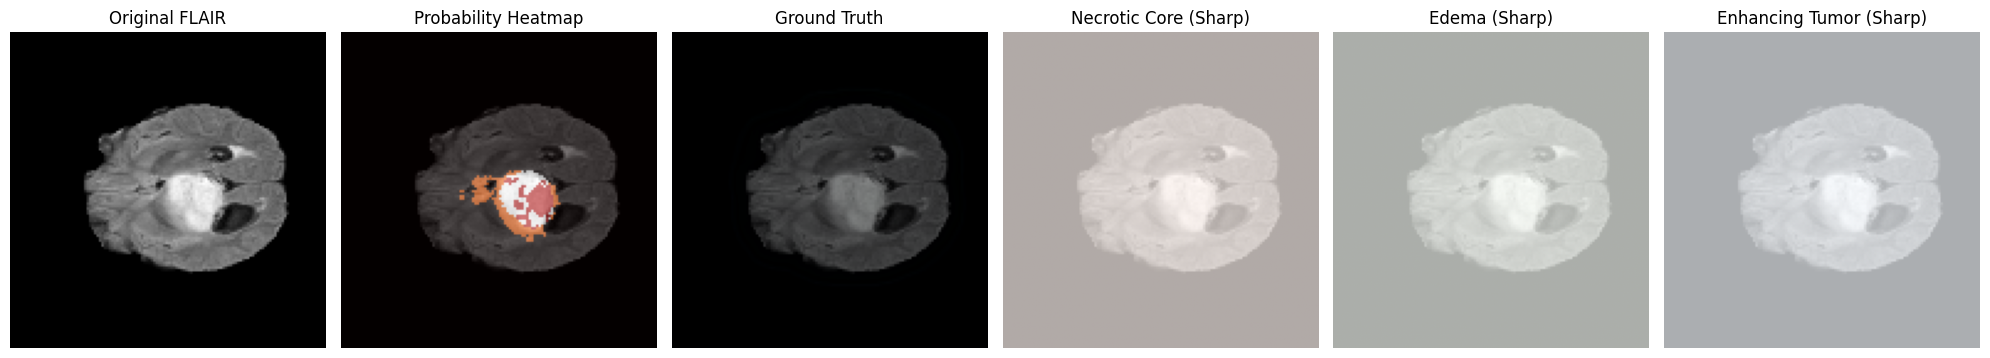


Dice Scores for slice 70:
Necrotic/Core: 0.000
Edema: 0.000
Enhancing: 1.000
Average: 0.333
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


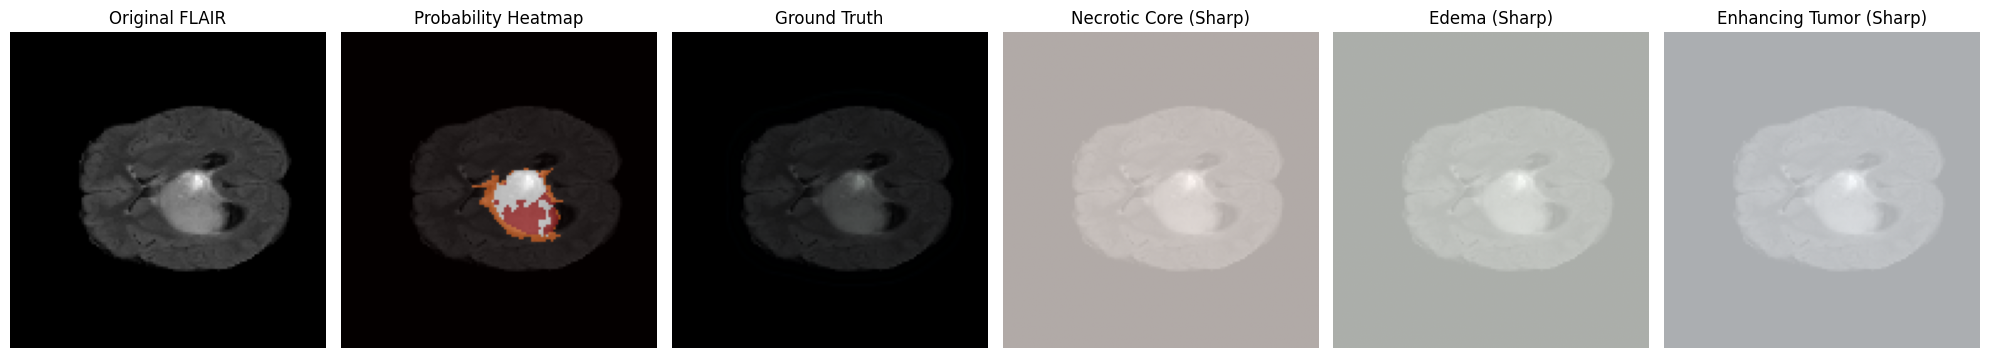


Dice Scores for slice 80:
Necrotic/Core: 0.000
Edema: 0.000
Enhancing: 1.000
Average: 0.333


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import cv2
import os

def predictByPath(model, case_path, case_id):
    """
    Predict tumor segmentation for a given case

    Args:
        model: Trained 3D U-Net model
        case_path: Path to the case directory
        case_id: Case identifier
    """
    X = np.zeros((1, IMG_SIZE, IMG_SIZE, IMG_SIZE, 3))

    flair = nib.load(os.path.join(case_path, f'{case_id}_flair.nii')).get_fdata()
    t1ce = nib.load(os.path.join(case_path, f'{case_id}_t1ce.nii')).get_fdata()
    t1 = nib.load(os.path.join(case_path, f'{case_id}_t1.nii')).get_fdata()

    for j in range(IMG_SIZE):
        X[0, :, :, j, 0] = cv2.resize(flair[:, :, j], (IMG_SIZE, IMG_SIZE))
        X[0, :, :, j, 1] = cv2.resize(t1ce[:, :, j], (IMG_SIZE, IMG_SIZE))
        X[0, :, :, j, 2] = cv2.resize(t1[:, :, j], (IMG_SIZE, IMG_SIZE))

    X = X / np.max(X)

    return model.predict(X, verbose=1)


def showPredictsById(model, case_id, data_path, start_slice=64, threshold=0.1):
    """
    Show predictions for a given case with improved sharpness

    Args:
        model: Trained 3D U-Net model
        case_id: Case identifier (e.g., 'BraTS20_Training_001')
        data_path: Path to the dataset
        start_slice: Slice index to visualize
        threshold: Probability threshold for segmentation
    """
    case_path = os.path.join(data_path, case_id)

    gt = nib.load(os.path.join(case_path, f'{case_id}_seg.nii')).get_fdata()
    flair = nib.load(os.path.join(case_path, f'{case_id}_flair.nii')).get_fdata()

    predictions = predictByPath(model, case_path, case_id)

    # Extract predictions and create sharp masks
    background = predictions[0, :, :, :, 0]
    necrotic = predictions[0, :, :, :, 1]
    edema = predictions[0, :, :, :, 2]
    enhancing = predictions[0, :, :, :, 3]

    # Create binary masks using a threshold
    necrotic_mask = (necrotic[:, :, start_slice] > threshold).astype(np.uint8)
    edema_mask = (edema[:, :, start_slice] > threshold).astype(np.uint8)
    enhancing_mask = (enhancing[:, :, start_slice] > threshold).astype(np.uint8)

    plt.figure(figsize=(20, 6))

    # Original FLAIR
    plt.subplot(161)
    plt.imshow(cv2.resize(flair[:, :, start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    plt.title('Original FLAIR')
    plt.axis('off')

    # Ground Truth
    plt.subplot(162)
    gt_slice = cv2.resize(gt[:, :, start_slice], (IMG_SIZE, IMG_SIZE),
                         interpolation=cv2.INTER_NEAREST)
    plt.imshow(cv2.resize(flair[:, :, start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    plt.imshow(gt_slice, cmap="hot", alpha=0.5)
    plt.title('Probability Heatmap')
    plt.axis('off')

    # Probability Heatmap
    plt.subplot(163)
    combined_pred = np.zeros((IMG_SIZE, IMG_SIZE, 3))
    combined_pred[:, :, 0] = necrotic[:, :, start_slice]
    combined_pred[:, :, 1] = edema[:, :, start_slice]
    combined_pred[:, :, 2] = enhancing[:, :, start_slice]
    plt.imshow(cv2.resize(flair[:, :, start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    plt.imshow(combined_pred, alpha=0.5)
    plt.title('Ground Truth')
    plt.axis('off')

    # Sharp Binary Masks
    plt.subplot(164)
    plt.imshow(cv2.resize(flair[:, :, start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    plt.imshow(necrotic_mask, cmap='Reds', alpha=0.7)
    plt.title('Necrotic Core (Sharp)')
    plt.axis('off')

    plt.subplot(165)
    plt.imshow(cv2.resize(flair[:, :, start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    plt.imshow(edema_mask, cmap='Greens', alpha=0.7)
    plt.title('Edema (Sharp)')
    plt.axis('off')

    plt.subplot(166)
    plt.imshow(cv2.resize(flair[:, :, start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    plt.imshow(enhancing_mask, cmap='Blues', alpha=0.7)
    plt.title('Enhancing Tumor (Sharp)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Calculate Dice scores (using binary masks)
    dice_scores = []
    gt_slice = gt_slice.astype(int)

    for i in range(1, 4):
        gt_binary = (gt_slice == i).astype(np.float32)

        # Select the appropriate binary prediction mask
        if i == 1:
            pred_binary = necrotic_mask
        elif i == 2:
            pred_binary = edema_mask
        else:
            pred_binary = enhancing_mask

        intersection = np.sum(gt_binary * pred_binary)
        union = np.sum(gt_binary) + np.sum(pred_binary)
        if union > 0:
            dice = 2 * intersection / union
        else:
            dice = 1.0 if intersection == 0 else 0.0
        dice_scores.append(dice)

    print("\nDice Scores for slice {}:".format(start_slice))
    print(f"Necrotic/Core: {dice_scores[0]:.3f}")
    print(f"Edema: {dice_scores[1]:.3f}")
    print(f"Enhancing: {dice_scores[2]:.3f}")
    print(f"Average: {np.mean(dice_scores):.3f}")

for i in range(5):  # Show first 5 test cases
    print(f"\nCase {test_ids[i]}")
    showPredictsById(model, test_ids[i], TRAIN_DATASET_PATH)

case_id = test_ids[0]
for slice_idx in [50, 60, 70, 80]:  # View different slices
    showPredictsById(model, case_id, TRAIN_DATASET_PATH, start_slice=slice_idx)

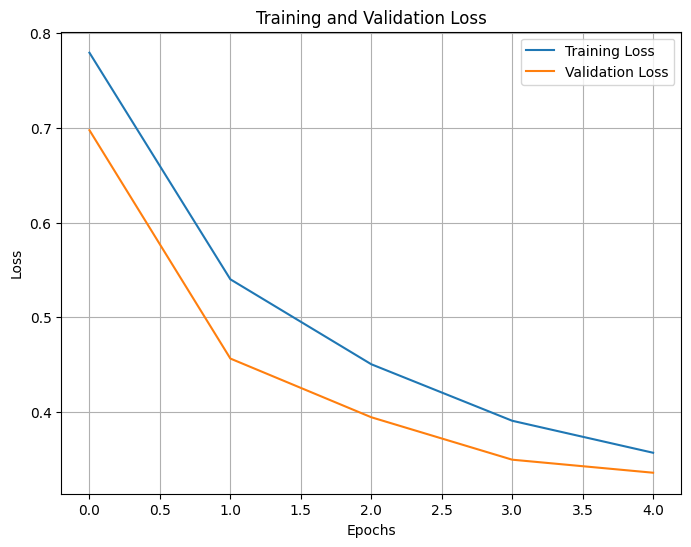

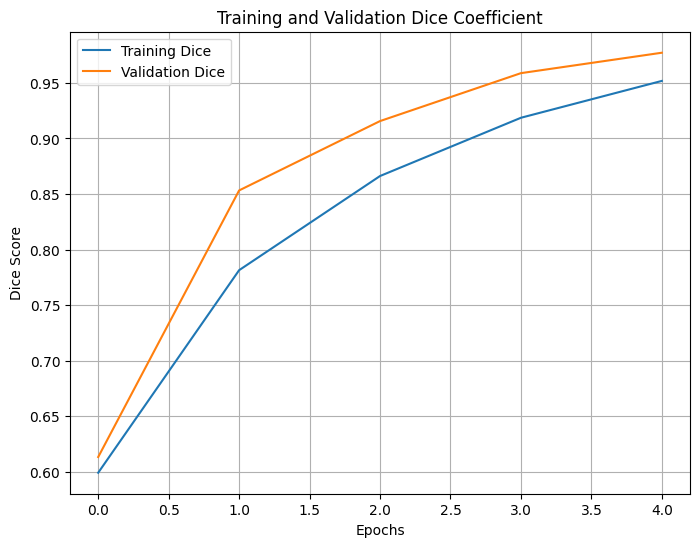

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have 'history' object from model.fit()
# Plot Loss Curve
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_curve.png')   # <-- This saves the figure
plt.show()

# Plot Dice Score Curve (or Accuracy if you tracked that)
plt.figure(figsize=(8, 6))
plt.plot(history.history['dice_coef'], label='Training Dice')
plt.plot(history.history['val_dice_coef'], label='Validation Dice')
plt.title('Training and Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.legend()
plt.grid(True)
plt.savefig('dice_score_curve.png')  # <-- Save this figure too
plt.show()
